In [18]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timm

In [19]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
device

'cuda'

1. Define the model
2. Load the model state
3. Define hook for activations
4. Register the hook using layer name
5. Run the forward pass to run the hook and collect the activations
6. Remove the hook for 

In [21]:
# Loading the base model
conv_base = timm.create_model("xception", pretrained=True, num_classes = 0, global_pool = '')

class IntegratedModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.base = conv_base
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, X):
        X = self.base(X)
        X = self.gap(X)
        X = self.flatten(X)
        return self.classifier(X)

model = IntegratedModel().to(device)
summary(model, (3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 89, 89]             864
       BatchNorm2d-2           [-1, 32, 89, 89]              64
              ReLU-3           [-1, 32, 89, 89]               0
            Conv2d-4           [-1, 64, 87, 87]          18,432
       BatchNorm2d-5           [-1, 64, 87, 87]             128
              ReLU-6           [-1, 64, 87, 87]               0
            Conv2d-7           [-1, 64, 87, 87]             576
            Conv2d-8          [-1, 128, 87, 87]           8,192
   SeparableConv2d-9          [-1, 128, 87, 87]               0
      BatchNorm2d-10          [-1, 128, 87, 87]             256
             ReLU-11          [-1, 128, 87, 87]               0
           Conv2d-12          [-1, 128, 87, 87]           1,152
           Conv2d-13          [-1, 128, 87, 87]          16,384
  SeparableConv2d-14          [-1, 128,

In [22]:
#Loading the model

model.load_state_dict(torch.load('best_model_fine.pth', map_location=device))
model.eval()
print("Model loaded successfully")

Model loaded successfully


In [32]:
# Loading the image and convert it to tensor
import requests
from PIL import Image
from io import BytesIO
from torchvision import transforms

url = "https://img-datasets.s3.amazonaws.com/cat.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((180,180)),
    transforms.ToTensor()
])

image_tensor = transform(img).unsqueeze(0).to(device)

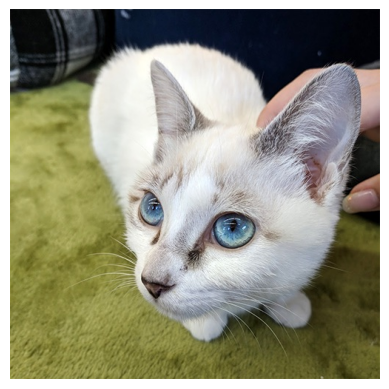

In [33]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [39]:
#Defining the hooks and managing the hooks

class HookManager:
    def __init__(self, layers):
        self.activations = {}
        self.layer_names = []
        self.handles = []

        for name, layer in layers:
            handle = layer.register_forward_hook(self.get_activation(name))
            self.handles.append(handle)
            self.layer_names.append(name)
    
    def get_activation(self, name):
        def hook(model, input, output):
            self.activations[name] = output.detach()
        return hook
    
    def __enter__(self):
        return self
    
    def __exit__(self, type, value, traceback):
        for h in self.handles:
            h.remove()

modules = [(name, layer) for name, layer in model.named_modules() if isinstance(layer, (nn.Conv2d, nn.MaxPool2d))]

with HookManager(modules) as hm: #To remember for myself: internally, hm = HookManager.__enter__()
    with torch.no_grad():
        model(image_tensor)


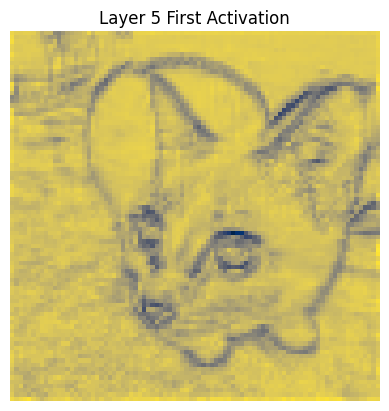

In [58]:
# Visualizing certain activation from the certain layer

activations = hm.activations
layer_names = hm.layer_names

layer_5 = layer_names[4]
layer5_activation = activations[layer_5].cpu().numpy()

plt.imshow(layer5_activation[0, 1, :, :], cmap="cividis")
plt.title("Layer 5 First Activation")
plt.axis('off')
plt.show()

In [ ]:
#Show all activation in grid


78